<a href="https://colab.research.google.com/github/mbc2009/Inferno/blob/main/AISI/Soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U plotly

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import networkx as nx
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from io import BytesIO
from scipy.spatial.transform import Rotation

**TOC**<a id='toc0_'></a>    
1. [QM/DFT/TB](#toc1_)    
1.1. [Q1a](#toc1_1_)    
1.2. [Q1b](#toc1_2_)    
1.3. [Q1c](#toc1_3_)    
2. [Q2: Group Theorem](#toc2_)    
2.1. [Q2a](#toc2_1_)    
2.2. [Q2b](#toc2_2_)    
2.3. [Q2c](#toc2_3_)    
3. [Q3: GNN/MPNN](#toc3_)    
3.1. [Q3a](#toc3_1_)    
3.2. [Q3b](#toc3_2_)    
3.3. [Q3c](#toc3_3_)    
3.4. [Q3d](#toc3_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---
# 1. <a id='toc1_'></a>[QM/DFT/TB](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Q1a](#toc0_)

**Step 1: General Hamiltonian and Atomic Basis**

To begin with, we start from the general form of [Hamiltonian operator](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)):
$$
\begin{aligned}
\hat{H}
&=
\hat{T} + \hat{V} \\
&=
\frac{\mathbf{\hat{p}} \cdot \mathbf{\hat{p}}}{2m} + V(\mathbf{r})\\
&=
-\frac{\hbar^2}{2m} \nabla^2 + V(\mathbf{r})
\end{aligned}
$$
where $V(\mathbf{r})$ is the periodic potential due to the lattice.

For a 1D chain with lattice constant $a$, the potential is periodic: $V(x + a) = V(x)$.
In the [tight-binding (TB) model](https://en.wikipedia.org/wiki/Tight_binding), we approximate $V(x)$ as the sum of atomic potentials centered at each lattice site.

Considering the atomic orbitals of a single atom. For an isolated atom at position $\mathbf{r}_j = j a$, the Hamiltonian is:
$$
H_{\text{atom}} = -\frac{\hbar^2}{2m} \nabla^2 + U(x - j a)
$$
where $U(x - j a)$ is the atomic potential at site $j$.

According to the general form of [Schrödinger equation](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation):
$$
\hat{H} \,
\Psi(\mathbf{r},t)
=
E \,
\Psi(\mathbf{r},t),
$$
the eigenstate of this atomic Hamiltonian can be derived as:
$$
\left( -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + U(x - j a) \right) \phi(x - j a) = E_0 \phi(x - j a)
$$
where $\phi(x - j a)$ is the atomic orbital centered at site $j$, which we denote as $|j\rangle$. $E_0$ is the energy of the atomic orbital.


\
**Step 2: Construct the Crystal Potential**

In the crystal, the potential is the sum of atomic potentials from all sites:
$$
V(x)
=
\sum_j U(x - j a)
$$

$\therefore$ the full Hamiltonian becomes:
$$
H =
-\frac{\hbar^2}{2m}
\frac{d^2}{dx^2} +
\sum_j U(x - j a)
$$

$\because$ we can rewrite the potential as:
$$
V(x) = U(x - r_j) + \sum_{j' \neq j} U(x - r_{j'})
$$

$\therefore$ the Hamiltonian for an electron near site $j$ is:
$$
\begin{aligned}
H &=
\left(
	-\frac{\hbar^2}{2m}
	\frac{d^2}{dx^2}
	+ U(x - r_j)
\right)
+ \sum_{j'
\neq j} U(x - r_{j'})\\
&=
H_{\text{atom}} +
\sum_{j' \neq j}
U(x - r_{j'})
\end{aligned}
$$
where the first part is the atomic Hamiltonian $H_{\text{atom}}$, and the second part is the contribution from other atoms $\sum_{j' \neq j} U(x - r_{j'})$.

In the [tight-binding (TB) approximation](https://www.youtube.com/watch?v=vGyHgaXnAMA), we assume the atomic orbitals are localized, so the contribution of $U(x - r_{j'})$ for $j' \neq j$ is small unless $j'$ is a nearest neighbor.


\
**Step 3: Tight-Binding Approximation and Matrix Elements**

We use the atomic orbitals $\phi(x - r_j)$ as the basis to construct the crystal wavefunction. The problem specifies that each atom has only one orbital and we neglect spin degrees of freedom. We assume the orbitals are orthogonal for simplicity: $\langle j | j' \rangle = \delta_{jj'}$. The crystal wavefunction is expressed as:
$$
\psi(x) = \sum_j a_j \phi(x - r_j)
$$

Substituting $|\psi\rangle$ into the Schrödinger equation $H|\psi\rangle = E|\psi\rangle$, we get:
$$
H \sum_j a_j |j\rangle = E \sum_j a_j |j\rangle
$$

Project onto $\langle k|$, we have:
$$
\sum_j a_j \langle k | H | j \rangle = E a_k
$$

We need to compute the matrix elements $\langle k | H | j \rangle$. For the on-site term ($k = j$):
$$
\begin{aligned}
\langle k | H | k \rangle
&=
\langle k |
\left(
-\frac{\hbar^2}{2m}
\frac{d^2}{dx^2} +
\sum_j U(x - r_j)
\right)
| k \rangle\\
&=
\langle
k |
\left(
-\frac{\hbar^2}{2m}
\frac{d^2}{dx^2} +
U(x - r_k)
\right) |
k
\rangle +
\sum_{j \neq k}
\langle
k | U(x - r_j) | k
\rangle
\end{aligned}
$$
The first term is $\langle k | H_{\text{atom}} | k \rangle = E_0$, and the second term is the correction due to other atoms:
$$
J_0 = \langle k | U(x - r_j) | k \rangle \quad (j \neq k)
$$

Since $\phi(x - r_k)$ is localized, $J_0$ is typically small. In tight-binding models, this correction is often absorbed into the on-site energy as a constant shift, so we define:
$$
\epsilon = E_0 - J_0
$$
Thus:
$$
\langle k | H | k \rangle \approx \epsilon
$$

For off-diagonal terms ($k \neq j$):
$$
\langle k | H | j \rangle = \langle k | \left( -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + \sum_m U(x - r_m) \right) | j \rangle
$$

The dominant contribution comes from the potential at site $j$:
$$
\langle k | U(x - r_j) | j \rangle = \int \phi^*(x - r_k) U(x - r_j) \phi(x - r_j) \, dx
$$

We define the hopping integral:
$$
J_n = - \int \phi^*(x - r_m) U(x - r_j) \phi(x - r_j) \, dx \quad (r_m - r_j = n a)
$$

For nearest neighbors ($n = \pm 1$):
$$
J_1 = - \int \phi^*(x - r_k) U(x - r_{k+1}) \phi(x - r_{k+1}) \, dx
$$

$\therefore$ we have:
$$
\langle k | H | k+1 \rangle \approx - J_1
$$

Since the system is symmetric, $\langle k+1 | H | k \rangle = \langle k | H | k+1 \rangle^* = - J_1$ (assuming real orbitals). \

In tight-binding models, we define the hopping parameter $t = -J_1$. Since $J_1$ is typically negative (due to the attractive nature of $U$), $t$ is positive.


\
**Step 4: Construct the Tight-Binding Hamiltonian**

Using the nearest-neighbor approximation, the tight-binding Hamiltonian is:
$$
H = \sum_k \epsilon |k\rangle\langle k| - \sum_k J_1 \left( |k\rangle\langle k+1| + |k+1\rangle\langle k| \right)
$$

Substituting $t = -J_1$, we rewrite the Hamiltonian as:
$$
H = \sum_k \epsilon |k\rangle\langle k| + \sum_k t \left( |k\rangle\langle k+1| + |k+1\rangle\langle k| \right)
$$


\
**Step 5: Apply Bloch's Theorem to Solve Energy Bands**

Now we use [Bloch's theorem](https://en.wikipedia.org/wiki/Bloch%27s_theorem) for a periodic system. The wavefunction takes the form:
$$
|\psi_k\rangle = \sum_n e^{ikna} |n\rangle
$$
where $k$ is the wavevector in the first Brillouin zone $[-\pi/a, \pi/a]$.

Substitute into $H|\psi_k\rangle = E(k)|\psi_k\rangle$:
$$
H|\psi_k\rangle = \sum_n e^{ikna} \left( \epsilon |n\rangle - J_1 |n-1\rangle - J_1 |n+1\rangle \right)
$$

The on-site term gives:
$$
\epsilon |\psi_k\rangle = \epsilon \sum_n e^{ikna} |n\rangle
$$

The hopping term gives:
$$
-J_1 \sum_n e^{ikna} \left( |n-1\rangle + |n+1\rangle \right) = -J_1 \left( e^{-ika} + e^{ika} \right) \sum_n e^{ikna} |n\rangle
$$

Since:
$$
e^{ika} + e^{-ika} = 2 \cos(ka)
$$
and $t = -J_1$, the hopping term becomes:
$$
-J_1 (e^{ika} + e^{-ika}) |\psi_k\rangle = -J_1 \cdot 2 \cos(ka) |\psi_k\rangle = 2 t \cos(ka) |\psi_k\rangle
$$

Thus, the eigenvalue equation is:
$$
\left( \epsilon + 2 t \cos(ka) \right) |\psi_k\rangle = E(k) |\psi_k\rangle
$$

The energy dispersion relation is:
$$
\boxed{
E(k) = \epsilon + 2t \cos(ka)
}
$$

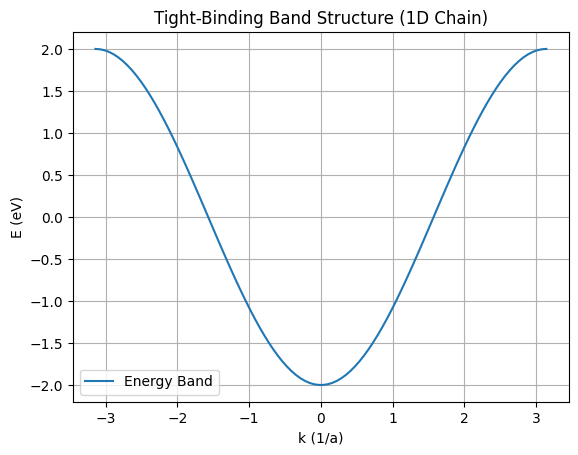

In [ ]:
# Parameters
a = 1.0                           # lattice constant (arbitrary units)
epsilon0 = 0.0                    # on-site energy (arbitrary units)
t = -1.0                          # hopping parameter (arbitrary units)
k_points = np.linspace(-np.pi/a,  # k-points in Brillouin zone
                       np.pi/a, 100)

# Energy dispersion
E_k = epsilon0 + 2 * t * np.cos(k_points * a)  # 修正符号

# Plot
plt.plot(k_points, E_k, label='Energy Band')
plt.xlabel('k (1/a)')
plt.ylabel('E (eV)')
plt.title('Tight-Binding Band Structure (1D Chain)')
plt.legend()
plt.grid(True)
plt.show()

---
## 1.2. <a id='toc1_2_'></a>[Q1b](#toc0_)

**Step 1: Define the System and Basis**\
The positions of atoms in the $n$-th unit cell are:
- Atom A at $x = na$,
- Atom B at $x = na + d$ (where $d$ is the distance between A and B within the cell; for simplicity, assume uniform spacing, so $d = a/2$).

Each atom has one orbital, and we neglect spin. The basis for the $ n $-th unit cell consists of:
- $|n, A\rangle$: orbital on atom A,
- $|n, B\rangle$: orbital on atom B.

The on-site energies are:
- $ \epsilon_A = \langle n, A | H | n, A \rangle $,
- $ \epsilon_B = \langle n, B | H | n, B \rangle $.

We assume the orbitals are orthogonal: $ \langle n, \alpha | m, \beta \rangle = \delta_{nm} \delta_{\alpha\beta} $, where $ \alpha, \beta = A, B $.


\
**Step 2: Construct the Tight-Binding Hamiltonian**\
Using the nearest-neighbor approximation (as in Q1a), we consider hopping between adjacent atoms. The hopping parameter $ t $ (where $ t > 0 $) is defined as:
$$
t = -\langle n, A | H | n, B \rangle = -\langle n, B | H | n+1, A \rangle,
$$
assuming symmetry in hopping between A and B.

The Hamiltonian includes:
- On-site terms: $ \epsilon_A |n, A\rangle\langle n, A| $, $ \epsilon_B |n, B\rangle\langle n, B| $.
- Hopping within the unit cell (A to B): $ -t |n, A\rangle\langle n, B| - t |n, B\rangle\langle n, A| $.
- Hopping between unit cells (B to A of the next cell): $ -t |n, B\rangle\langle n+1, A| - t |n+1, A\rangle\langle n, B| $.

Thus, the Hamiltonian is:
$$
\begin{aligned}
H
&=
\sum_n
\bigg(
\epsilon_A |n, A\rangle\langle n, A|
+ \epsilon_B |n, B\rangle\langle n, B| \\
&\quad - t \big(
|n, A\rangle\langle n, B|
+ |n, B\rangle\langle n, A|
+ |n, B\rangle\langle n+1, A|
+ |n+1, A\rangle\langle n, B|
\big)
\bigg).
\end{aligned}
$$


\
**Step 3: Apply Bloch's Theorem**\
The wavefunction for a Bloch state with wavevector $ k $ is:
$$
|\psi_k\rangle = \sum_n e^{ikna} \left( a_k |n, A\rangle + b_k |n, B\rangle \right),
$$
where $ a_k $ and $ b_k $ are the coefficients for the A and B orbitals in the Bloch state.

Substitute into the Schrödinger equation $ H|\psi_k\rangle = E|\psi_k\rangle $, and project onto $ \langle m, A| $ and $ \langle m, B| $:

- **Project onto $ \langle m, A| $**:
$$
\langle m, A | H | \psi_k \rangle = \epsilon_A a_k e^{ikma} - t b_k e^{ikma} - t b_k e^{ik(m-1)a} = E a_k e^{ikma}.
$$
Divide through by $ e^{ikma} $:
$$
\epsilon_A a_k - t b_k - t b_k e^{-ika} = E a_k.
$$

- **Project onto $ \langle m, B| $**:
$$
\langle m, B | H | \psi_k \rangle = \epsilon_B b_k e^{ikma} - t a_k e^{ikma} - t a_k e^{ik(m+1)a} = E b_k e^{ikma}.
$$
Divide through by $ e^{ikma} $:
$$
\epsilon_B b_k - t a_k - t a_k e^{ika} = E b_k.
$$

This gives the matrix equation:
$$
\begin{pmatrix}
\epsilon_A - E & -t (1 + e^{-ika}) \\
-t (1 + e^{ika}) & \epsilon_B - E
\end{pmatrix}
\begin{pmatrix}
a_k \\
b_k
\end{pmatrix}
= 0.
$$


\
**Step 4: Solve the Secular Equation**\
For a non-trivial solution, the determinant must be zero:
$$
(\epsilon_A - E)(\epsilon_B - E) - t^2 (1 + e^{-ika})(1 + e^{ika}) = 0.
$$

Compute the hopping term:
$$
(1 + e^{-ika})(1 + e^{ika}) = 1 + e^{ika} + e^{-ika} + 1 = 2 + 2 \cos(ka) = 4 \cos^2(ka/2),
$$
since $ 1 + \cos(ka) = 2 \cos^2(ka/2) $.

The equation becomes:
$$
(\epsilon_A - E)(\epsilon_B - E) - 4 t^2 \cos^2(ka/2) = 0.
$$

Expand and rearrange:
$$
E^2 - (\epsilon_A + \epsilon_B) E + \epsilon_A \epsilon_B - 4 t^2 \cos^2(ka/2) = 0.
$$

Solve the quadratic equation for $ E $:
$$
E = \frac{\epsilon_A + \epsilon_B \pm \sqrt{(\epsilon_A + \epsilon_B)^2 - 4 (\epsilon_A \epsilon_B - 4 t^2 \cos^2(ka/2))}}{2}.
$$

Simplify the discriminant:
$$
(\epsilon_A + \epsilon_B)^2 - 4 (\epsilon_A \epsilon_B - 4 t^2 \cos^2(ka/2)) = (\epsilon_A - \epsilon_B)^2 + 16 t^2 \cos^2(ka/2).
$$


$\therefore$ the energy bands are:
$$
\boxed{E = \frac{\epsilon_A + \epsilon_B}{2} \pm \sqrt{\left(\frac{\epsilon_A - \epsilon_B}{2}\right)^2 + 4 t^2 \cos^2(ka/2)}}
$$


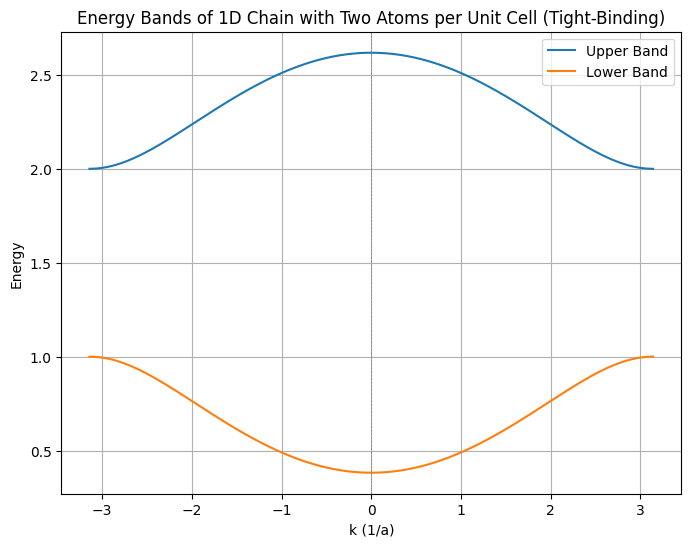

In [ ]:
# Define parameters
a = 1.0           # Lattice constant
epsilon_A = 1.0   # On-site energy for atom A
epsilon_B = 2.0   # On-site energy for atom B
t = 0.5           # Hopping parameter (positive)

# Define k-points in the first Brillouin zone [-pi/a, pi/a]
k = np.linspace(-np.pi/a, np.pi/a, 1000)

# Compute the energy bands
'''
E(k) = (epsilon_A + epsilon_B)/2 ± sqrt(((epsilon_A - epsilon_B)/2)^2 + 4*t^2*cos^2(ka/2))
'''
term1 = (epsilon_A + epsilon_B) / 2
term2 = np.sqrt(((epsilon_A - epsilon_B) / 2)**2 + 4 * t**2 * np.cos(k * a / 2)**2)

E_plus = term1  + term2  # Upper band
E_minus = term1 - term2  # Lower band

# Plot the energy bands
plt.figure(figsize=(8, 6))
plt.plot(k, E_plus, label='Upper Band')
plt.plot(k, E_minus, label='Lower Band')
plt.xlabel('k (1/a)')
plt.ylabel('Energy')
plt.title('Energy Bands of 1D Chain with Two Atoms per Unit Cell (Tight-Binding)')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

---
## 1.3. <a id='toc1_3_'></a>[Q1c](#toc0_)

**Step 1: Define the System and Basis**\
The chain has a lattice constant $a$, with each unit cell containing two atoms:
- Atom A (blue) at $x = na$,
- Atom B (red) at $x = na + d$, where $d < a/2$ due to non-uniform spacing.

Each atom has one orbital, and we neglect spin. The basis for the $ n $-th unit cell is:
- $ |n, A\rangle $: orbital on atom A,
- $ |n, B\rangle $: orbital on atom B.

On-site energies are $ \epsilon_A $ and $ \epsilon_B $, and we assume orthogonality: $ \langle n, \alpha | m, \beta \rangle = \delta_{nm} \delta_{\alpha\beta} $.


\
**Step 2: Construct the Tight-Binding Hamiltonian**\
Due to non-uniform spacing, the hopping terms differ:
- Distance between A and B within the same cell ($ n $-th cell): $ d $,
- Distance between B and A of the next cell ($ (n+1) $-th cell): $ a - d $.

Define the hopping parameters:
- $ t_1 = -\langle n, A | H | n, B \rangle $: hopping within the unit cell (distance $ d $),
- $ t_2 = -\langle n, B | H | n+1, A \rangle $: hopping between unit cells (distance $ a - d $).

The Hamiltonian includes:
- On-site terms: $ \epsilon_A |n, A\rangle\langle n, A| $, $ \epsilon_B |n, B\rangle\langle n, B| $,
- Hopping within the unit cell: $ -t_1 |n, A\rangle\langle n, B| - t_1 |n, B\rangle\langle n, A| $,
- Hopping between unit cells: $ -t_2 |n, B\rangle\langle n+1, A| - t_2 |n+1, A\rangle\langle n, B| $.

Thus:
$$
\begin{aligned}
H &= \sum_n \bigg(
    \epsilon_A |n, A\rangle\langle n, A|
    + \epsilon_B |n, B\rangle\langle n, B| \\
&\quad - t_1 \big(
|n, A\rangle\langle n, B|
    + |n, B\rangle\langle n, A| \big)
- t_2 \big( |n, B\rangle\langle n+1, A|
    + |n+1, A\rangle\langle n, B|
\big)
\bigg).
\end{aligned}
$$



\
**Step 3: Apply Bloch's Theorem**\
Using the Bloch wavefunction from Q1b:
$$
|\psi_k\rangle = \sum_n e^{ikna} \left( a_k |n, A\rangle + b_k |n, B\rangle \right),
$$
substitute into $ H|\psi_k\rangle = E|\psi_k\rangle $, and project onto $ \langle m, A| $ and $ \langle m, B| $:

- **Project onto $ \langle m, A| $**:
$$
\epsilon_A a_k e^{ikma} - t_1 b_k e^{ikma} - t_2 b_k e^{ik(m-1)a} = E a_k e^{ikma},
$$
$$
\epsilon_A a_k - t_1 b_k - t_2 b_k e^{-ika} = E a_k.
$$

- **Project onto $ \langle m, B| $**:
$$
\epsilon_B b_k e^{ikma} - t_1 a_k e^{ikma} - t_2 a_k e^{ik(m+1)a} = E b_k e^{ikma},
$$
$$
\epsilon_B b_k - t_1 a_k - t_2 a_k e^{ika} = E b_k.
$$

This gives the matrix equation:
$$
\begin{pmatrix}
\epsilon_A - E & -t_1 - t_2 e^{-ika} \\
-t_1 - t_2 e^{ika} & \epsilon_B - E
\end{pmatrix}
\begin{pmatrix}
a_k \\
b_k
\end{pmatrix}
= 0.
$$



\
**Step 4: Solve the Secular Equation**\
Set the determinant to zero:
$$
(\epsilon_A - E)(\epsilon_B - E) - (t_1 + t_2 e^{-ika})(t_1 + t_2 e^{ika}) = 0.
$$

Compute the hopping term:
$$
(t_1 + t_2 e^{-ika})(t_1 + t_2 e^{ika}) = t_1^2 + t_2^2 + t_1 t_2 (e^{ika} + e^{-ika}) = t_1^2 + t_2^2 + 2 t_1 t_2 \cos(ka).
$$

The equation becomes:
$$
(\epsilon_A - E)(\epsilon_B - E) - (t_1^2 + t_2^2 + 2 t_1 t_2 \cos(ka)) = 0.
$$

Expand and solve the quadratic equation:
$$
E^2 - (\epsilon_A + \epsilon_B) E + \epsilon_A \epsilon_B - (t_1^2 + t_2^2 + 2 t_1 t_2 \cos(ka)) = 0.
$$

Discriminant:
$$
\Delta = (\epsilon_A + \epsilon_B)^2 - 4 \left( \epsilon_A \epsilon_B - (t_1^2 + t_2^2 + 2 t_1 t_2 \cos(ka)) \right) = (\epsilon_A - \epsilon_B)^2 + 4 (t_1^2 + t_2^2 + 2 t_1 t_2 \cos(ka)).
$$


$\therefore$ the energy bands are:
$$
\boxed{E = \frac{\epsilon_A + \epsilon_B}{2} \pm \sqrt{\left(\frac{\epsilon_A - \epsilon_B}{2}\right)^2 + t_1^2 + t_2^2 + 2 t_1 t_2 \cos(ka)}}
$$

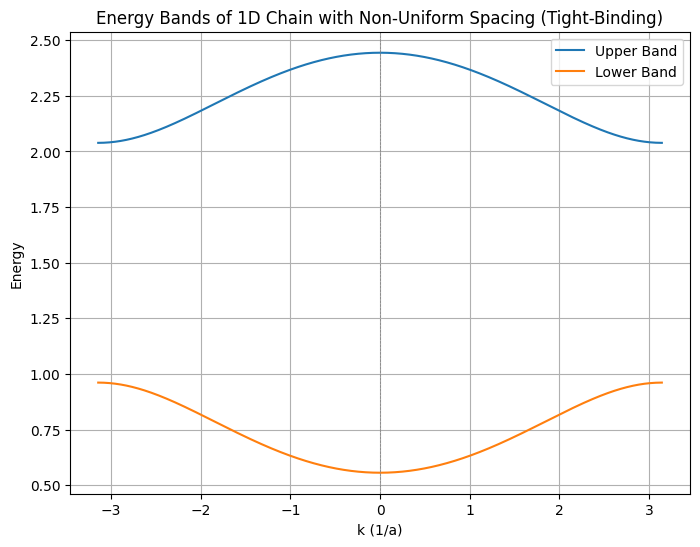

In [ ]:
# Define parameters
a = 1.0  # Lattice constant
epsilon_A = 1.0  # On-site energy for atom A
epsilon_B = 2.0  # On-site energy for atom B
t1 = 0.5         # ⚠️ Hopping parameter within unit cell (A to B)
t2 = 0.3         # ⚠️ Hopping parameter between unit cells (B to next A)

# Define k-points in the first Brillouin zone [-pi/a, pi/a]
k = np.linspace(-np.pi/a, np.pi/a, 1000)

# Compute the energy bands
'''
E(k) = (epsilon_A + epsilon_B)/2 ± sqrt(((epsilon_A - epsilon_B)/2)^2 + t1^2 + t2^2 + 2*t1*t2*cos(ka))
'''
term1 = (epsilon_A + epsilon_B) / 2
term2 = np.sqrt(((epsilon_A - epsilon_B) / 2)**2 + t1**2 + t2**2 + 2 * t1 * t2 * np.cos(k * a))

E_plus = term1  + term2  # Upper band
E_minus = term1 - term2  # Lower band

# Plot the energy bands
plt.figure(figsize=(8, 6))
plt.plot(k, E_plus, label='Upper Band')
plt.plot(k, E_minus, label='Lower Band')
plt.xlabel('k (1/a)')
plt.ylabel('Energy')
plt.title('Energy Bands of 1D Chain with Non-Uniform Spacing (Tight-Binding)')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

---
# 2. <a id='toc2_'></a>[Q2: Group Theorem](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Q2a](#toc0_)

**E(3) Group**
The E(3) group, known as the [Euclidean group](https://en.wikipedia.org/wiki/Euclidean_group) in three dimensions, consists of all isometries preserving distances in 3D space. It is the semidirect product of the special orthogonal group SO(3) (rotations) and the translation group T(3), denoted as \( E(3) = SO(3) \ltimes T(3) \). This group captures both rotational and translational symmetries, critical for describing physical systems in 3D.

\
**Relation with SO(3) and O(3)**\
- [SO(3)](https://en.wikipedia.org/wiki/3D_rotation_group): The special orthogonal group in 3D, comprising proper rotations (3×3 matrices with determinant +1). It is a subgroup of E(3), focusing solely on rotational symmetry.
- [O(3)](https://en.wikipedia.org/wiki/Orthogonal_group): The orthogonal group in 3D, including both proper rotations (SO(3)) and improper rotations (e.g., reflections, determinant ±1). While O(3) extends SO(3) by adding reflections, E(3) further incorporates translations, making O(3) a subgroup of E(3) when translations are excluded.

\
**Clebsch-Gordan Coefficients**\
[Clebsch-Gordan coefficients](https://en.wikipedia.org/wiki/Clebsch%E2%80%93Gordan_coefficients) are coefficients used in quantum mechanics to couple two angular momentum states into a total angular momentum state.\
For two states $|j_1 m_1\rangle$ and $|j_2 m_2\rangle$, the combined state is:
$$
|J M\rangle = \sum_{m_1, m_2} \langle j_1 m_1 j_2 m_2 | J M \rangle |j_1 m_1\rangle |j_2 m_2\rangle,
$$
where $\langle j_1 m_1 j_2 m_2 | J M \rangle$ are the Clebsch-Gordan coefficients.
They decompose the tensor product of SO(3) representations ($j_1 \otimes j_2$) into a direct sum of irreducible representations, essential for symmetry analysis in physical systems.

---
## 2.2. <a id='toc2_2_'></a>[Q2b](#toc0_)

[Equivariance](https://en.wikipedia.org/wiki/Equivariant_map) refers to a property where a function or operator transforms consistently under a group action, such as the E(3) group of 3D rotations and translations.

Unlike invariance (where the output remains unchanged), equivariance ensures the output transforms in a predictable way aligned with the input's transformation, preserving physical consistency.

Mathematically, for a quantum operator $\hat{O}$ in an atomic orbital basis and a rotation $R \in SO(3)$, equivariance requires:
$$
\hat{O}' = U(R) \hat{O} U(R)^\dagger,
$$
where $U(R)$ is the unitary representation of $R$ in the basis. For p-orbitals ($l = 1$), $U(R)$ is a 3^3 rotation matrix acting on $\{p_x, p_y, p_z\}$, reflecting their vector-like transformation.

**Examples**:
- **Vector field**: An electric field $\mathbf{E}$ rotates as $\mathbf{E}' = R \mathbf{E}$ under SO(3).
- **Stress tensor**: A rank-2 tensor transforms as $\sigma'_{ij} = R_{ik} R_{jl} \sigma_{kl}$, maintaining its physical meaning under rotations.

---
## 2.3. <a id='toc2_3_'></a>[Q2c](#toc0_)


**Meaning of Equivariance**\
In the atomic orbital basis (e.g., p-orbitals), equivariance of a quantum operator $ \hat{O} $ under E(3) means its matrix representation transforms consistently with spatial rotations. For a rotation $ R \in SO(3) $, the basis $ \{|p_x\rangle, |p_y\rangle, |p_z\rangle\} $ transforms as $ |p_i'\rangle = U(R) |p_i\rangle $, where $ U(R) $ is the 3$\times$3 rotation matrix for $ l = 1 $. The operator matrix changes as:
$$ O' = U(R) O U(R)^\dagger, $$
ensuring physical properties (e.g., hopping integrals) remain consistent under coordinate transformations.

**Verification of $ O1 $ and $ O2 $**\
Given $ O1 $ and $ O2 $ as p-p interaction matrices with direction vectors $ \text{vec1} = [-0.0193, 5.3152, 0.0518] $ and $ \text{vec2} = [0, 0, 1] $, they are equivariant if $ O2 = R O1 R^T $, where $ R $ rotates $ \text{vec1} $ to $ \text{vec2} $.

- **Formula**:\
  For p-orbitals, $ U(R) = R $, so:
  $$ O2 = R O1 R^T. $$

- **Steps**:
  1. Normalize $ \text{vec1} $ and $ \text{vec2} $.
  2. Compute $ R $ using the rotation axis (cross product) and angle (dot product).
  3. Verify $ O2 \approx R O1 R^T $.

In [ ]:
# input data
O1 = np.array([[1.32661455e-01,   2.88550062e-03, -5.17760229e-04],
            [6.94089346e-05, -1.87958878e-02, 5.87849393e-04],
            [-7.18132899e-04, 5.75661802e-04, -1.89961633e-02]])
vec1 = np.array([-0.0193, 5.3152, 0.0518])

O2 = np.array([[-0.0188, -0.0006, 0.0005],
               [-0.0006, -0.0190, -0.0007],
               [-0.0023, -0.0005, 0.1327]])
vec2 = np.array([0., 0., 1.])


# norm. vec
v1 = vec1 / np.linalg.norm(vec1)
v2 = vec2 / np.linalg.norm(vec2)

# cal. the rot. mtx. R
rot = Rotation.align_vectors([v2], [v1])[0]
R = rot.as_matrix()

# verify rot
print("R * vec1:", R @ v1)
print("vec2:", v2)

# re-order
P = np.array([[0, 0, 1], [1, 0, 0], [0, 1, 0]])
O1_adjusted = P @ O1 @ P.T

# cal. O2'
O2_pred = R @ O1_adjusted @ R.T
print("\nO2 (expected):\n", O2)
print("O2' (computed):\n", O2_pred)
print("\nMax difference:\n", np.max(np.abs(O2 - O2_pred)))

R * vec1: [ 7.58941521e-19 -1.87350135e-16  1.00000000e+00]
vec2: [0. 0. 1.]

O2 (expected):
 [[-0.0188 -0.0006  0.0005]
 [-0.0006 -0.019  -0.0007]
 [-0.0023 -0.0005  0.1327]]
O2' (computed):
 [[-1.89943806e-02 -5.88407930e-04 -1.66835486e-04]
 [-5.88417263e-04 -1.88145280e-02  1.40833210e-03]
 [ 4.37709938e-05 -1.40703911e-03  1.32678313e-01]]

Max difference:
 0.0023437709938002346


---
# 3. <a id='toc3_'></a>[Q3: GNN/MPNN](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Q3a](#toc0_)

Basically, at each layer, the GNN/MPNN model will iteratively extract the information from the previous and current layers and execute the following three updating rules, propagating information from local to global scales to update node and edge representations:

**Step 1. Message Generating**<a id="eq1"></a>

The message $\mathbf{m}^{ij,L}$ integrates the state of the sending node $j$ and the receiving node $i$, along with the edge information $\mathbf{e}^{ij,L-1}$ from their relationship at the previous $(L-1)^{\text{th}}$ layer.
$$
\begin{aligned}
&\boxed{
  \mathbf{m}^{ij,L}
  \;=\;
  M_L
  \left(
    \mathbf{n}^{i,L-1},\,
    \mathbf{n}^{j,L-1},\,
    \mathbf{e}^{ij,L-1}\;\;
  \right)
}\\
&\text{
  $\mathbf{m}^{ij,L}$: Message vector sent from node $j$ to node $i$ at the $L^{\text{th}}$ layer.}\\
&\text{  
  $\mathbf{M_L}$: Learnable message function with parameters specific to layer $L$}\\
&\text{  
  $\mathbf{n}^{i,L-1} \& \mathbf{n}^{j,L-1}$: State (or feature) vectors of nodes $i$ and $j$ at the previous $(L-1)^{\text{th}}$ layer.}\\
&\text{  
  $\mathbf{e}^{ij,L-1}$: State (or feature) vector of the edge between nodes $i$ and $j$ at the previous $(L-1)^{\text{th}}$ layer.}\\
\end{aligned}
\tag{1}
$$
$\mathbf{M_L}$ typically implemented as a neural network (e.g., MLP).

**Step 2. Node Updating**

The updated node state $\mathbf{n}^{i,L}$ is computed by aggregating messages from all neighboring nodes $j$ and combining them with the node's previous state $\mathbf{n}^{i,L-1}$ .
Usually, the operator $U_L$ here is a weighted summation followed by an activation function.
$$
\begin{aligned}
&\boxed{
  \mathbf{n}^{i,L}
  \;=\;
  U_L\!
  \left(
    \mathbf{n}^{i,L-1},\,
    \sum_{j \in \mathcal{N}(i)}
    \mathbf{m}^{ij,L}\;\;
  \right)
}\\
&\text{
  $\mathbf{n}^{i,L}$: Updated state vector of node $i$ at the $L^{\text{th}}$ layer.}\\
&\text{  
  $U_L$: Learnable update function for layer $L$, typically a neural network.}\\
&\text{  
  $\sum_{j \in \mathcal{N}(i)}, \mathbf{m}^{ij,L}$: Sum of messages from all neighbors $j$ in the neighborhood $\mathcal{N}(i)$ of node $i$.}\\
\end{aligned}
$$

**Step 3. Edge Updating**

The current edge state $\mathbf{e}^{ij,L}$ of the edge between $i$ and $j$, $(i,j)$, is updated based on the current states of the connected nodes $i$ and nodes $j$ and their previous edge state.
$$
\begin{aligned}
&\boxed{
  \mathbf{e}^{ij,L}
  \;=\;
  \mathcal{N}_L
  \left(
      \mathbf{n}^{i,L},\,
      \mathbf{n}^{j,L},\,
      \mathbf{e}^{ij,L-1}\,\,
  \right)
}\\
&\text{
  $\mathbf{e}^{ij,L}$: Updated state vector of the edge between nodes $i$ and $j$ at the $L^{\text{th}}$ layer.}\\
&\text{
  $\mathcal{N}_L$: Learnable edge update function for layer $L$, typically a neural network.}\\
&\text{
  $\mathbf{n}^{i,L} \,\&\, \mathbf{n}^{j,L}$: Current state vectors of nodes $i$ and $j$.}\\
&\text{
  $\mathbf{e}^{ij,L-1}$: Previous state vector of the edge at the $(L-1)^{\text{th}}$ layer.}\\
\end{aligned}
$$

---
## 3.2. <a id='toc3_2_'></a>[Q3b](#toc0_)

In the classical GNN/MPNN model, as the depth of the layers increases, each node gradually aggregates (extracts and stores) information from an expanding set of nodes, potentially reaching all others in the graph through multi-hop propagation, *i.e.*, losing its locality.

However, for a machine learning model like [DeePTB](https://github.com/deepmodeling/DeePTB), to better preserve its locality and achieve a strictly local receptive field, a new parameter $\mathbf{V}$ has been introduced into the previous formula to modulate the scope of information propagation.

The vertex feature associated with the edge between nodes $i$ and $j$ at layer $L$, *i.e.*, $\mathbf{V}^{ij,L}$, is iteratively and strictly updated using information aggregated from the master node $i$ itself via:
$$
\mathbf{V}^{ij,L}
=
\mathcal{V}_L
\left(
  \mathbf{n}^{i,L-1}\;, \;
  \mathbf{V}^{ij,L-1} \;\;
\right),
$$
and this information is then passed into $\mathbf{m}^{ij,L}$ through:
$$
\mathbf{m}^{ij,L}
=
M_L
\left(
  \mathbf{n}^{i,L-1}\;,\;
  \mathbf{V}^{ij,L}\;\;
\right)
$$
rather than incorporating the node state of its neighboring node $j$ at the previous layer ($\mathbf{n}^{j,L-1}\,$ ), as done in eq.[1](#eq1).

This means, unlike the classical GNN/MPNN model, the information stored in node $i$ no longer contains contributions aggregated from its neighboring nodes $j$ and their connected edge $(i,j)$, unless $\mathbf{V}^{ij,L=0} \,\,$  contains the neighboring nodes' feature information.

Instead, this information is collected in the connected edge state $\mathbf{e}^{ij,L}$ via
$$
\mathbf{e}^{ij,L}
\;=\;
\mathcal{N}_L
\left(
  \mathbf{n}^{i,L},\,
  \mathbf{V}^{ij,L},\,
  \mathbf{n}^{j,L},\,
  \mathbf{e}^{ij,L-1}\;\;
\right).
$$

Therefore, the most significant difference between the classical GNN/MPNN and the modified version used in DeePTB lies in the introduction of the $\mathbf{V}^{ij,L}$ term, which enforces the accompanying locality.

---
## 3.3. <a id='toc3_3_'></a>[Q3c](#toc0_)

**1. Assumptions**

For simplicity we assume $\mathbf{n}^{i,L}$, $\mathbf{V}^{ij,L}$, $\mathbf{m}^{ij,L}$, and $\mathbf{e}^{ij,L}$ are all scalars.

Furthermore, we then use simple linear transformations for $\mathcal{V}_L$, $M_L$, $U_L$, and $\mathcal{N}_L$.

*e.g.*:
$$
\boxed{
\begin{aligned}
\mathcal{V}_L(a, b) &= w_v a + b\\
M_L(a, b) &= w_m a + b\\
U_L(a, b) &= w_u a + b\\
\mathcal{N}_L(a, b, c, d) &= w_e (a + b + c + d)\\
\end{aligned}
}
$$

Here, $w_v, w_m, w_u, w_e$ are learnable weights initialized as 0.5, 0.5, 0.5, and 0.2 respectively.

**2. Layer Construction**

A honeycomb lattice is a two-dimensional hexagonal grid, where each node has $3$ nearest neighbors.

We build a small lattice and use NetworkX to generate the lattice structure, relabeling nodes with consecutive integers for easier indexing.

**3. Code Algorithm**

1. **Lattice Generation**
   - Use `networkx.hexagonal_lattice_graph` to create a 4×4 honeycomb lattice, where each node has 3 nearest neighbors.
   - Nodes are automatically labeled by NetworkX as tuples (e.g., `(i, j, s)`), then remapped to consecutive integers (0 to 47) using a dictionary for compatibility with PyTorch indexing.

2. **Update Formula Implementation**
   - Implement a `DeePTBLayer` class to update $\mathbf{V}^{ij,L}$, $\mathbf{m}^{ij,L}$, $\mathbf{n}^{i,L}$, and $\mathbf{e}^{ij,L}$.
   - All features are scalars; $\mathcal{V}_L$, $M_L$, $U_L$, and $\mathcal{N}_L$ are simplified to linear transformations with learnable weights.
   - The forward pass iterates over edges to compute vertex features, messages, node updates, and edge updates.

3. **Locality Test & Visualization**
   - Pick a center node $i$ (e.g., 15) and a distant node $k$ (e.g., 0) with distance > 1, ensuring $k$ is not within $i$'s nearest neighborhood.
   - **$1_{\text{st}}$ run**: Initialize every node feature to 1.
   - **$2_{\text{nd}}$ run**: Set the distant node $k$'s initial feature to 10.
   - Compare the final feature of the center node $i$ in both runs.
   - Since DeePTB's update formula (single-layer) depends only on nearest neighbors, changes in the distant node $k$ should not affect the center node $i$. This verifies locality.
   - Visualize the lattice using Matplotlib after first run and second run, highlighting the center node (red), distant node (blue), center node's neighbors (green), and other nodes (gray) with node labels.


In [ ]:
def generate_honeycomb_lattice(rows, cols):
    G = nx.hexagonal_lattice_graph(rows, cols, periodic=False)
    mapping = {node: idx for idx, node in enumerate(G.nodes)}
    G = nx.relabel_nodes(G, mapping)
    return G

def visualize_lattice(G,
                      center_node: int,
                      far_node: int,
                      node_features_base,
                      edge_features_base,
                      node_features_modified,
                      edge_features_modified, pos=None):
    # Calculate node positions if not provided
    if pos is None:
        # Use spring_layout with adjusted parameters for better spreading
        pos = nx.spring_layout(
            G,
            k=1.5 / np.sqrt(len(G.nodes)),  # Smaller k for more repulsion
            iterations=200,                 # More iterations for better optimization
            scale=2.0,                      # Scale up the layout
            # Optionally, provide an initial geometric position for honeycomb
            # pos=initial_honeycomb_positions(G, rows=4, cols=4)
        )

    # Set node colors
    node_colors = ['lightgray'] * len(G.nodes)
    node_colors[center_node] = 'red'
    node_colors[far_node] = 'blue'
    for neighbor in G.neighbors(center_node):
        node_colors[neighbor] = 'green'

    # Extract node coordinates
    x_nodes = [pos[node][0] for node in G.nodes]
    y_nodes = [pos[node][1] for node in G.nodes]

    # Edge coordinates and feature values
    edge_index_map = {edge: idx for idx, edge in enumerate(G.edges)}
    x_edges, y_edges = [], []
    edge_hovertexts_base = []
    edge_hovertexts_modified = []
    for edge in G.edges:
        i, j = edge
        x0, y0 = pos[i]
        x1, y1 = pos[j]
        x_edges.extend([x0, x1, None])
        y_edges.extend([y0, y1, None])
        edge_idx = edge_index_map[edge]
        edge_hovertexts_base.append(f"Edge ({i}, {j}): {edge_features_base[edge_idx]:.4f}")
        edge_hovertexts_modified.append(f"Edge ({i}, {j}): {edge_features_modified[edge_idx]:.4f}")

    # Node labels and feature values
    node_labels_base = [f"Node {i}<br>n_i: {node_features_base[i]:.4f}" for i in G.nodes]
    node_labels_modified = [f"Node {i}<br>n_i: {node_features_modified[i]:.4f}" for i in G.nodes]

    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("After First Run", "After Second Run"))

    # Subplot 1: First run
    fig.add_trace(go.Scatter(
        x=x_edges, y=y_edges,
        mode='lines',
        line=dict(color='gray', width=2),
        hoverinfo='text',
        hovertext=edge_hovertexts_base,
        showlegend=False
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers+text',
        marker=dict(size=10, color=node_colors),
        text=[str(i) for i in G.nodes],
        textposition="top center",
        hoverinfo='text',
        hovertext=node_labels_base,
        showlegend=False
    ), row=1, col=1)

    # Subplot 2: Second run
    fig.add_trace(go.Scatter(
        x=x_edges, y=y_edges,
        mode='lines',
        line=dict(color='gray', width=2),
        hoverinfo='text',
        hovertext=edge_hovertexts_modified,
        showlegend=False
    ), row=1, col=2)

    fig.add_trace(go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers+text',
        marker=dict(size=10, color=node_colors),
        text=[str(i) for i in G.nodes],
        textposition="top center",
        hoverinfo='text',
        hovertext=node_labels_modified,
        showlegend=False
    ), row=1, col=2)

    # Update layout
    fig.update_layout(
        title_text="Honeycomb Lattice: Center Node (Red), Far Node (Blue), Neighbors (Green)",
        width=1200,
        height=600,
        showlegend=False
    )
    fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False)

    fig.show()

def initial_honeycomb_positions(G, rows, cols):
    pos = {}
    idx = 0
    for i in range(rows):
        for j in range(cols):
            # Two nodes per unit cell in hexagonal lattice (A and B sublattices)
            # A sublattice
            x_a = j * 3.0  # Adjust spacing
            y_a = i * np.sqrt(3) * 1.5
            # B sublattice (offset)
            x_b = x_a + 1.5
            y_b = y_a + np.sqrt(3) * 0.5
            # Map nodes based on index
            pos[idx] = (x_a, y_a)
            idx += 1
            if idx < len(G.nodes):
                pos[idx] = (x_b, y_b)
                idx += 1
    return pos

class DeePTBLayer(nn.Module):
    def __init__(self):
        super(DeePTBLayer, self).__init__()
        self.w_v = nn.Parameter(torch.tensor(0.5))
        self.w_m = nn.Parameter(torch.tensor(0.5))
        self.w_u = nn.Parameter(torch.tensor(0.5))
        self.w_e = nn.Parameter(torch.tensor(0.2))

    def forward(self, G, node_features, vertex_features, edge_features):
        num_nodes = len(G.nodes)
        num_edges = len(G.edges)
        new_node_features = torch.zeros(num_nodes)
        new_vertex_features = torch.zeros(num_edges)
        new_edge_features = torch.zeros(num_edges)

        edge_index_map = {edge: idx for idx, edge in enumerate(G.edges)}

        for edge in G.edges:
            i, j = edge
            edge_idx = edge_index_map[edge]
            new_vertex_features[edge_idx] = self.w_v * node_features[i] + vertex_features[edge_idx]

        messages = torch.zeros(num_nodes, num_nodes)
        for edge in G.edges:
            i, j = edge
            edge_idx = edge_index_map[edge]
            messages[i, j] = self.w_m * node_features[i] + new_vertex_features[edge_idx]

        for i in G.nodes:
            message_sum = sum(messages[i, j] for j in G.neighbors(i) if (i, j) in G.edges)
            new_node_features[i] = self.w_u * node_features[i] + message_sum

        for edge in G.edges:
            i, j = edge
            edge_idx = edge_index_map[edge]
            new_edge_features[edge_idx] = self.w_e * (
                new_node_features[i] + new_vertex_features[edge_idx] +
                new_node_features[j] + edge_features[edge_idx]
            )

        return new_node_features, new_vertex_features, new_edge_features

def test_locality(center_node: int, far_node: int):
    G = generate_honeycomb_lattice(4, 4)
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)

    print(f"Nodes in graph: {list(G.nodes)}")
    print(f"Number of nodes: {num_nodes}, Number of edges: {num_edges}")

    node_features = torch.ones(num_nodes)
    vertex_features = torch.zeros(num_edges)
    edge_features = torch.zeros(num_edges)

    neighbors = list(G.neighbors(center_node))
    print(f"Neighbors of center node {center_node}: {neighbors}")
    assert far_node not in neighbors, f"Far node {far_node} is a neighbor of {center_node}!"

    num_layers = 1
    model = DeePTBLayer()

    pos = nx.spring_layout(G, k=1.5/np.sqrt(len(G.nodes)), iterations=200, scale=2.0)

    node_features_base = node_features.clone()
    vertex_features_base = vertex_features.clone()
    edge_features_base = edge_features.clone()
    for _ in range(num_layers):
        node_features_base, vertex_features_base, edge_features_base = model(
            G, node_features_base, vertex_features_base, edge_features_base
        )

    node_features_modified = node_features.clone()
    node_features_modified[far_node] = 10.0
    vertex_features_modified = vertex_features.clone()
    edge_features_modified = edge_features.clone()
    for _ in range(num_layers):
        node_features_modified, vertex_features_modified, edge_features_modified = model(
            G, node_features_modified, vertex_features_modified, edge_features_modified
        )

    visualize_lattice(G, center_node, far_node, node_features_base, edge_features_base,
                     node_features_modified, edge_features_modified, pos=pos)

    print(f"Center node {center_node} feature (base): {node_features_base[center_node]:.4f}")
    print(f"Center node {center_node} feature (modified): {node_features_modified[center_node]:.4f}")
    assert torch.allclose(node_features_base[center_node], node_features_modified[center_node], atol=1e-5), \
        "Center node feature changed, locality not preserved!"

    print("Locality test passed: Center node feature is invariant to changes outside the receptive field.")

In [ ]:
# Execution (⚠️ re-execute this part for correctly displaying the graph representation in your local device)
if __name__ == "__main__":
    test_locality(center_node=23,
                  far_node=13)

Nodes in graph: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Number of nodes: 48, Number of edges: 63
Neighbors of center node 23: [22, 24, 33]


Center node 23 feature (base): 2.5000
Center node 23 feature (modified): 2.5000
Locality test passed: Center node feature is invariant to changes outside the receptive field.


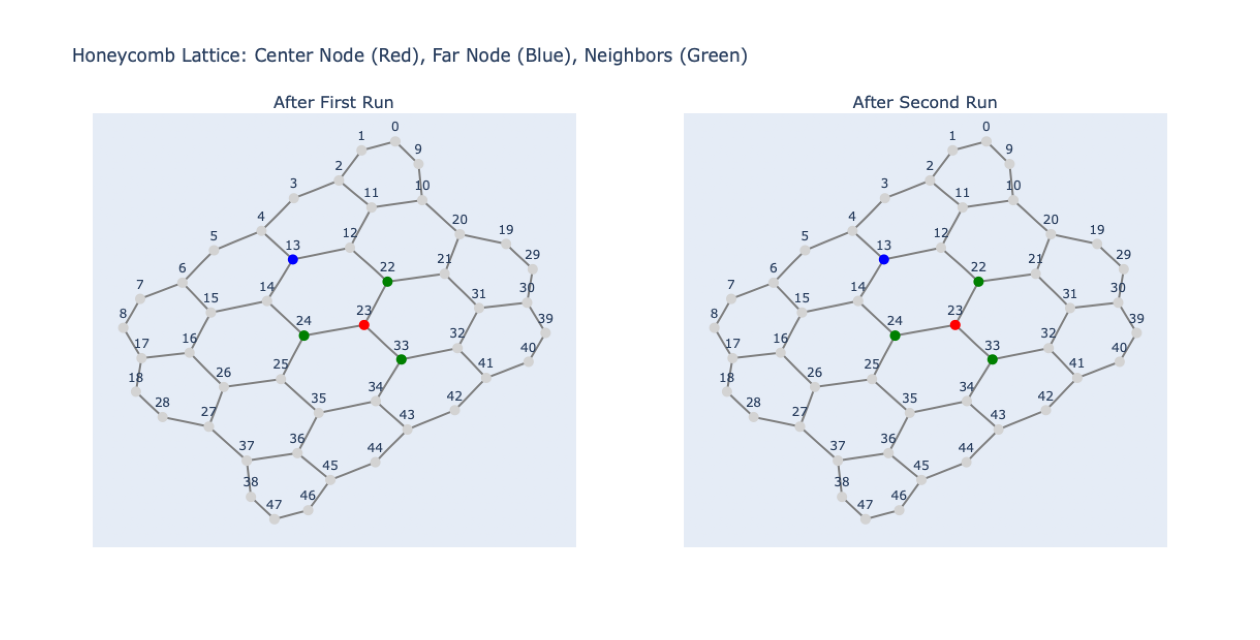

In [ ]:
## For making sure the image can be correctly rendered in any static reader

url = "https://raw.githubusercontent.com/mbc2009/Inferno/0ce745dcfcca999f998ddeba31642478472c09f1/AISI/newplot.png"

response = requests.get(url)
img = mpimg.imread(BytesIO(response.content), format='png')

plt.figure(figsize=(16, 9))
plt.imshow(img)
plt.axis('off')
plt.show()

**Result Analysis**  

When changing the mode state of `far_node' (node $k$ outside of the receptive field) $\mathbf{n}A^{k=13,L-1}$ from 1.5 tp 15, the node state of the center node $i$ $\mathbf{n}A^{k=23,L}$ remains 2.5 unchanged after 1 iteration.

This confirms that the DeePTB update framework is invariant to changes outside the nearest-neighbor range, satisfying strict locality.

---
## 3.4. <a id='toc3_4_'></a>[Q3d](#toc0_)

The traditional approach to GNN training often involves storing an adjacency matrix:
$$
E
=
\left( e^{ij} \right)_{1 \leq i, j \leq n-1} \;\;
=
\begin{bmatrix}
e^{00} & e^{01} & \dots & e^{0,n-1} \\
e^{10} & e^{11} & \dots & e^{1,n-1} \\
\vdots &        &       & \vdots \\
e^{n0} & e^{n1} & \dots & e^{n,n-1}
\end{bmatrix}
$$
which contains edge state information $\mathbf{e}^{ij}$ for all nodes $i$ and $j$.

Given the large number of nodes $n$, $E$ is typically a massive and sparse matrix, often leading to out-of-memory issues on a single device. While an adjacency list is an alternative, it can also cause problems as the feature tensor length increases.

As the number of iterations increases, the layer depth grows, and local information from each node gradually propagates to a global scale. This requires loading the entire adjacency matrix (or adjacency list) at once, incurring a space complexity of $\mathcal{O}(n^2)$ (or $\mathcal{O}(n \cdot d)$ for an adjacency list, where $d$ is the number of edges).

In contrast, DeePTB operates differently due to its strict locality, where the number of adjacent neighbor nodes $j \in N(i)$ is limited and controlled. This reduces the space complexity to $\mathcal{O}(n \cdot k)$, where $k$ is the number of neighboring nodes within the receptive field (e.g., $k = 3$ for a honeycomb lattice).

For achieving parallelism, we can:


1. **Graph Partitioning**  
   - Divide graph \( G \) into \( P \) subgraphs using an algorithm like METIS, minimizing cut edges.  
   - Assign each subgraph \( G_i \) to a device.

2. **Boundary & Halo Management**  
   - Identify boundary nodes \( B_i \) in \( G_i \) (nodes linked to other subgraphs).  
   - Create a halo region per subgraph, including boundary nodes from neighbors.

3. **Parallel Inference**  
   - Each device computes GNN updates for its subgraph using local and halo node features.  
   - After each layer, exchange updated boundary features with neighboring devices.

4. **Optimization**  
   - Use non-blocking communication (e.g., MPI) to overlap computation and data transfer.  
   - Limit communication to boundary features.


**Pseudocode (C++-like)**
```cpp
void multi_device_inference(Graph G, int num_devices) {
    // Partition graph
    auto partitions = partition_graph(G, num_devices);
    Subgraph G_i = partitions[my_rank];
    auto B_i = get_boundary_nodes(G_i, partitions);
    auto halo = get_halo_nodes(B_i, partitions);

    // GNN inference loop
    for each layer in GNN {
        compute_local_updates(G_i, node_features, edge_features);
        for each neighbor_device {
            send_boundary_features(neighbor_device, B_i);
            recv_halo_features(neighbor_device, halo);
        }
        wait_for_communication();
    }
}
```

**Vital Difficulties**

Since the way of connection of GNN is random and fully customized, unlike topology such as binary tree or dragonfly, Graph in GNN is very difficult to come up with a generally and reliable mapping method to map from the source topology (Graph) to the target topology (*e.g.*, hypercubic).
Therefore, parallelization will face fatal problems such as  load balancing, communication lag, and synchronization.
